### **Keypoint Detection**

In [1]:
import cv2 as cv
import numpy as np
import inspect
import copy
from matplotlib import pyplot as plt
# from utils import Splitter

TEST_IMG = "test.jpeg"

In [129]:
### class for experimenting with keypoints, homography, stiching, etc..
class Splitter:
    def __init__(self, img, r_split, c_split, split_size):
        self.img = None
        self.r_split = None
        self.c_split = None
        self.split_size = None
        self.splits = None
        self.mod_splits = None
        self.split_img(img, r_split, c_split, split_size)

    def __getitem__(self, key):
        return self.splits[key]

    def restore(self):
        self.mod_splits = copy.deepcopy(self.splits)

    def split_img(self, img, r_split, c_split, split_size):
        self.img = np.copy(img)
        self.r_split = r_split
        self.c_split = c_split
        self.split_size = split_size

        splits = []
        m_size, n_size = img.shape[0], img.shape[1]
        remain_r, remain_c = m_size % r_split, n_size % c_split

        for i in range(r_split):
            row = []
            f_i, l_i = i == 0, i == c_split - 1
            start_i = i * (m_size // r_split) - (not f_i) * split_size // 2
            end_i = (i + 1) * (m_size // r_split) + (not l_i) * split_size // 2

            for j in range(c_split):
                f_j, l_j = j == 0, j == c_split - 1
                start_j = j * (n_size // c_split) - (not f_j) * split_size // 2
                end_j = (j + 1) * (n_size // c_split) + (not l_j) * split_size // 2

                split = (img[
                    start_i:end_i + l_i * remain_r,
                    start_j:end_j + l_j * remain_c,
                ] if img.ndim == 2 else
                img[
                    start_i:end_i + l_i * remain_r,
                    start_j:end_j + l_j * remain_c,
                    ::-1
                ])

                row.append(np.ascontiguousarray(split, dtype=np.uint8))
                
            splits.append(row)
        self.splits = splits
        self.mod_splits = copy.deepcopy(splits)

    def _draw_splits(self, orig=False, _rects=False, _color=None, _alpha=0.25):
        cp_splits = copy.deepcopy(self.splits if orig else self.mod_splits)
        c_ss = self.split_size

        if _rects:
            draw = lambda u, x, y, z: \
            cv.rectangle(
                u, (x[0] - c_ss, x[1] - c_ss) if z else x, # x <-> y
                y if z else (y[0] + c_ss, y[1] + c_ss),
                _color if _color else (255, 0, 0, 0.2), -1
            )  
        else:
            draw = lambda u, x, y, _ = None: \
            cv.line(u, x, y, _color if _color else (255, 0, 0), 3)

        for i, row in enumerate(cp_splits):
            for j, img in enumerate(row):
                c = np.copy(img)
                dx = c.shape[1] - c_ss
                dy = c.shape[0] - c_ss

                if j > 0:                   # left
                    draw(c, (c_ss, 0), (c_ss, len(c)), True)                    
                if j < self.c_split - 1:    # right
                    draw(c, (dx, 0), (dx, len(c)), False)
                if i > 0:                   # top
                    draw(c, (0, c_ss), (len(c[0]), c_ss), True)
                if i < self.r_split - 1:    # bot
                    draw(c, (0, dy), (len(c[0]), dy), False)
                if _rects:
                    c = cv.addWeighted(c, _alpha, img, 1 - _alpha, 0)
                cp_splits[i][j] = c

        return cp_splits

    def show(
        self,
        rrows: range = None,
        rcols: range = None,
        with_lines: bool = False,
        orig: bool = False,
        title: str = None,
        **kwargs
    ):
        drawspec_kw = inspect.signature(self._draw_splits).parameters
        showspec_kw = inspect.signature(plt.Axes.imshow).parameters
        drawspec_kw = {k : kwargs[k] for k, v in drawspec_kw.items() if k in kwargs}
        showspec_kw = {k : kwargs[k] for k, v in showspec_kw.items() if k in kwargs}
        
        if with_lines:
            cp_splits = self._draw_splits(**drawspec_kw)
        else:
            cp_splits = self.splits if orig else self.mod_splits

        rows = len(rrows) if rrows else len(cp_splits)
        cols = len(rcols) if rcols else len(cp_splits[0])
        _, axes = plt.subplots(rows, cols, figsize=(20,20))

        if rows == 1 and cols == 1:
            axes.imshow(cp_splits[0][0])
            if title:
                axes.set_title(title, **showspec_kw)
            return

        for ai, si in enumerate(rrows if rrows else range(rows)):
            for aj, sj in enumerate(rcols if rcols else range(cols)):
                if rows == 1:
                    axes[aj].imshow(cp_splits[si][sj], **showspec_kw)
                    axes[aj].set_title(f"Split {sj}", fontsize=15)
                elif cols == 1:
                    axes[ai].imshow(cp_splits[si][sj], **showspec_kw)
                    axes[ai].set_title(f"Split {sj}", fontsize=15)
                else:
                    axes[ai, aj].imshow(cp_splits[si][sj], **showspec_kw)
                    axes[ai, aj].set_title(f"Split {si}, {sj}", fontsize=15)
        
    def apply(self, transform, rrows: range = None, rcols: range = None, **kwargs):
        t_kw = inspect.signature(transform).parameters
        t_kw = {k : kwargs[k] for k, v in t_kw.items() if k in kwargs}
        accum = []

        for i in rrows if rrows else range(self.img):
            for j in rcols if rcols else range(self.img[0]):
                try: accum.append(transform(self.mod_splits[i][j], **t_kw))
                except Exception as e: print(e)
        
        return accum

    def apply_and_show(
        self,
        transform,
        rrows: range = None,
        rcols: range = None,
        with_lines: bool = False,
        title: str = None,
        **kwargs
    ):
        accum = self.apply(transform, rrows, rcols, **kwargs)
        self.show(rrows, rcols, with_lines, title, **kwargs)

        return accum


In [130]:
src = cv.imread(TEST_IMG)
if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)

img = src.copy()
r_split, c_split, split_size = 3, 3, 100
splits = Splitter(img, r_split, c_split, split_size)

In [ ]:
# splits.apply
splits.show(with_lines=True)

In [154]:
def apply_SIFT(img, min_s=0, flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS):
    sift = cv.SIFT_create()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    kp_des = [v for v in zip(kp, des) if v[0].size >= min_s]
    # [(k, d),(k, d)]
    [kp, des] = zip(*kp_des)
    img = cv.drawKeypoints(
        gray, kp, img, color=(0, 255, 0),
        flags=flags
    )

    return (img, kp, np.array(des))

# splits.restore()
# sift_data = splits.apply_and_show(
#     apply_SIFT,
#     rrows=range(0, 1),
#     rcols=range(1, 3),
#     with_lines=True,
#     _rects=True,
#     flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS,
#     cmap="gray"
# )

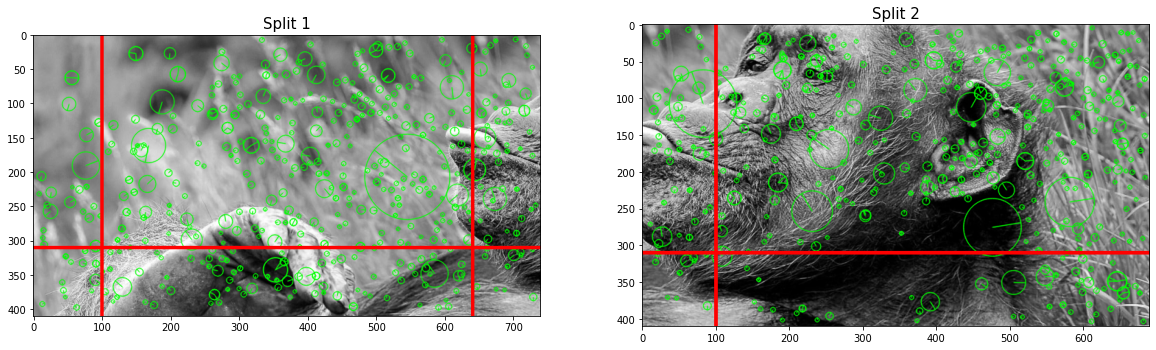

In [155]:
splits.restore()
sift_data = splits.apply_and_show(
    apply_SIFT,
    rrows=range(0, 1),
    rcols=range(1, 3),
    with_lines=True,
    # _rects=True,
    flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS,
    cmap="gray",
    min_s=5
)
[(split01, kp1, des1), (split02, kp2, des2)] = sift_data

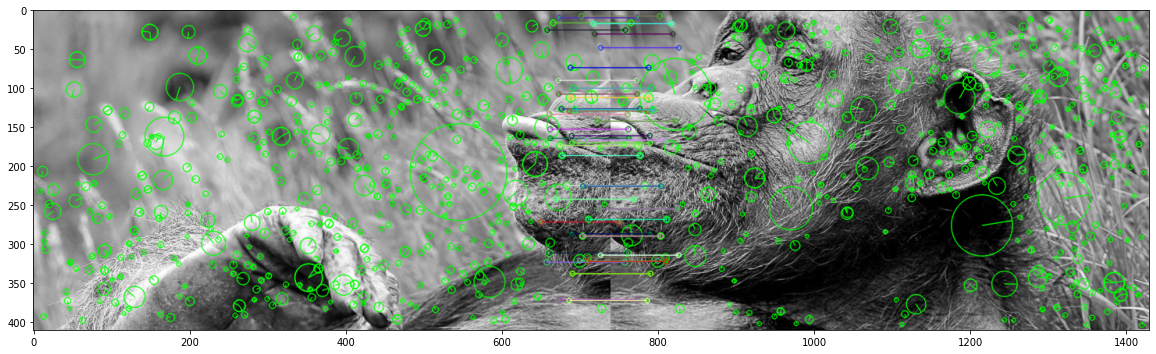

In [156]:
# splits.restore()
# [split01, split02] = splits[0][1:3]
# gray01 = cv.cvtColor(split01, cv.COLOR_BGR2GRAY)
# gray02 = cv.cvtColor(split02, cv.COLOR_BGR2GRAY)

# sift = cv.SIFT_create()
# kp1, des1 = sift.detectAndCompute(gray01, None)
# kp2, des2 = sift.detectAndCompute(gray02, None)

bf = cv.BFMatcher()
matches = bf.knnMatch(des1, des2, k=2)

# Apply ratio test
matches = [[m] for m, n in matches if m.distance < 0.5 * n.distance]
res = cv.drawMatchesKnn(
    split01,
    kp1,
    split02,
    kp2,
    matches,
    None,
    flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

plt.figure(figsize=(20,10))
plt.imshow(res)